# Contextual analytic geometric descent

## TODOs

* Outer loop plots.
* \>2 contexts, potentially with structure imposed.
* Geometric descent (makes gradient updates independent of gate-parameterization).
* Add gradient flows.

In [1]:
import functools
from collections import OrderedDict
import dill

import numpy
import pandas

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import scipy.interpolate

from hyperopt import fmin, tpe, Trials, hp

from timeit import default_timer

from qutip import basis, expect
from qutip.qip.operations import rx, rz

from qutip.operators import sigmax
from qutip.qip.operations import snot

from IPython.display import clear_output

from platform import python_version

import ipyparallel as ipp

# Local imports
from spectator_env_v2 import SpectatorEnvContinuousV2
from spectator_env_utils_v2 import extract_theta_phi, plot, plot_layered, get_error_unitary
from spectator_env_agent_v2 import ParallelSim

print(python_version())

c = ipp.Client()
v = c[:]

print(c.ids)

with v.sync_imports():
    import functools
    from collections import OrderedDict

    import numpy
    import pandas

    import scipy.interpolate

    from hyperopt import fmin, tpe, Trials, hp

    from timeit import default_timer

    from qutip import basis, expect
    from qutip.qip.operations import rx, rz

    from qutip.operators import sigmax
    from qutip.qip.operations import snot

    from IPython.display import clear_output

    # Local imports
    from spectator_env_v2 import SpectatorEnvContinuousV2
    from spectator_env_utils_v2 import extract_theta_phi, plot, plot_layered, get_error_unitary
    from spectator_env_agent_v2 import ParallelSim

%matplotlib inline
%load_ext autoreload
%autoreload 2

3.7.8
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
importing functools on engine(s)
importing OrderedDict from collections on engine(s)
importing numpy on engine(s)
importing pandas on engine(s)
importing scipy.interpolate on engine(s)
importing fmin,tpe,Trials,hp from hyperopt on engine(s)
importing default_timer from timeit on engine(s)
importing basis,expect from qutip on engine(s)
importing rx,rz from qutip.qip.operations on engine(s)
importing sigmax from qutip.operators on engine(s)
importing snot from qutip.qip.operations on engine(s)
importing clear_output from IPython.display on engine(s)
importing SpectatorEnvContinuousV2 from spectator_env_v2 on engine(s)
importing extract_theta_phi,plot,plot_layered,get_error_unitary from spectator_env_utils_v2 on engine(s)
importing ParallelSim from spectator_env_agent_v2 on engine(s)


In [2]:
%%px
import os
import psutil

p = psutil.Process(os.getpid())
print(p.cpu_affinity())

[stdout:0] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:1] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:2] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:3] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:4] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:5] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:6] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:7] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:8] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:9] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:10] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:11] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:12] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:13] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdout:14] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[stdo

## Helper functions

In [3]:
def context_loss(meas, trans):
    return numpy.var([numpy.pi - numpy.arccos(
        numpy.sqrt(t.overlap(meas) * meas.overlap(t))) for t in trans])


def correction_loss(meas, trans):
    return numpy.mean([numpy.pi - numpy.arccos(
        numpy.sqrt(t.overlap(meas) * meas.overlap(t))) for t in trans])


# This is the contour of the "true loss" for correction and contextualization.
def get_contour(error_samples, loss_fn, sensitivity=1.0):
    prepared_basis = [snot() * basis(2, 0), snot() * sigmax() * basis(2, 0)]
    trans = [get_error_unitary(sample, sensitivity) * prepared_basis[0]
             for sample in error_samples]

    thetas = numpy.linspace(0, numpy.pi, 33)
    phis = numpy.linspace(-numpy.pi, numpy.pi, 33)
    loss = numpy.zeros((len(thetas), len(phis)))

    min_phi = 0.
    min_theta = 0.
    min_loss = 1.

    max_phi = 0.
    max_theta = 0.
    max_loss = 0.
    for i, theta in enumerate(thetas):
        for j, phi in enumerate(phis):
            meas = numpy.cos(theta / 2) * prepared_basis[0] + numpy.exp(
                1j * phi) * numpy.sin(theta / 2) * prepared_basis[1]
            meas = meas.unit()

            objective = loss_fn(meas, trans)
            if (numpy.abs(objective) < min_loss):
                min_loss = objective
                min_phi = phi
                min_theta = theta
            if (numpy.abs(objective) > max_loss):
                max_loss = objective
                max_phi = phi
                max_theta = theta
            loss[i][j] = numpy.abs(objective)
    return {'thetas': thetas, 'phis': phis, 'loss': loss,
            'max_phi': max_phi, 'max_theta': max_theta,
            'min_phi': min_phi, 'min_theta': min_theta}

## Simulation

In [4]:
'''
Hyperparameters
'''

# Error distribution.
MU_1 = 0
SIGMA_1 = numpy.pi / 4
MU_2 = 0
SIGMA_2 = numpy.pi / 32
MU_3 = 0
SIGMA_3 = numpy.pi / 64

# Length of bit-string used to condition error distribution.
NUM_CONTEXT_SPECTATORS = 7

In [5]:
def run_sim(parallel_sims_store, context_eta, correction_eta, context_eta_init,
            correction_eta_init_1, correction_eta_init_2,
            batch_size, num_context_spectators,
            error_samples_generator_partial,
            feedback_spectators_allocation_function,
            num_batches_to_combine_context_feedback,
            num_batches_to_combine_correction_feedback,
            num_epochs, burnin_length):
    parallel_sim = ParallelSim(
                context_eta=context_eta, correction_eta=correction_eta,
                context_eta_init=context_eta_init,
                correction_eta_init=[correction_eta_init_1,
                                     correction_eta_init_2],
                batch_size=batch_size,
                num_context_spectators=num_context_spectators,
                error_samples_generator=error_samples_generator_partial,
                feedback_spectators_allocation_function=feedback_spectators_allocation_function,
                # How we vary batch size for context vs. correction feedback gradients.
                num_batches_to_combine_context_feedback=num_batches_to_combine_context_feedback,
                num_batches_to_combine_correction_feedback=num_batches_to_combine_correction_feedback)
    all_done = False
    # results = {p: [] for p in parallel_sims}
    # results can be polled for specific hyperparams
    for epoch in range(num_epochs):
        while not all_done:
            r = parallel_sim.step()
            all_done = r.done
        all_done = False
        if epoch % 50 == 0:
            print(f"Completed epoch {epoch}")
    parallel_sim.env.close()
    data_fids = numpy.array(parallel_sim.data_fidelity_per_episode[burnin_length:])
    ctrl_fids = numpy.array(parallel_sim.control_fidelity_per_episode[burnin_length:])
    loss = -numpy.mean(data_fids - ctrl_fids, axis=0)
    parallel_sims_store[loss] = parallel_sim
    parallel_sim.destruct()
    print(f"Loss: {loss}")
    return loss


def objective(args, parallel_sims_store, run_sim,
              error_samples_generator,
              feedback_spectators_allocation_function, mu, sigma,
              num_context_spectators, drift_strength, resource_regime):
    print(f"Args: {args}")
    context_eta_init = [args['context_theta_init_0'],
                        args['context_theta_init_1'],
                        args['context_theta_init_2']]
    correction_eta_init_1 = [args['correction_theta_init_1_0'],
                             args['correction_theta_init_1_1'],
                             args['correction_theta_init_1_2']]
    correction_eta_init_2 = [args['correction_theta_init_2_0'],
                             args['correction_theta_init_2_1'],
                             args['correction_theta_init_2_2']]
    # DO NOT MODIFY - set batch size via num_batches_to_combine...
    batch_size = 1 
    error_samples_generator_partial = functools.partial(
        error_samples_generator, mu=mu, sigma=sigma,
        batch_size=batch_size, drift=numpy.pi / drift_strength)
    num_epochs = int(numpy.ceil(1000 / batch_size))
    burnin_length = min(int(numpy.ceil(800 / batch_size)) - 1,
                        int(numpy.ceil(1000 / batch_size) -
                            numpy.ceil(2 * drift_strength / batch_size)))
    print(F"epochs: {num_epochs} burnin_length: {burnin_length} batch_size: {batch_size}")
    feedback_alloc = functools.partial(feedback_spectators_allocation_function,
                                       resource_regime)
    return run_sim(parallel_sims_store=parallel_sims_store,
                   context_eta_init=context_eta_init,
                   correction_eta_init_1=correction_eta_init_1,
                   correction_eta_init_2=correction_eta_init_2,
                   num_epochs=num_epochs,
                   burnin_length=burnin_length,
                   batch_size=batch_size,
                   correction_eta=args['correction_eta'],
                   context_eta=args['context_eta'],
                   error_samples_generator_partial=error_samples_generator_partial,
                   num_batches_to_combine_context_feedback=args['num_batches_to_combine_context_feedback'],
                   num_batches_to_combine_correction_feedback=args['num_batches_to_combine_correction_feedback'],
                   num_context_spectators=num_context_spectators,
                   feedback_spectators_allocation_function=feedback_alloc)


# minimize the objective over the space
# There are 4 critical params to tune => min 2**4 trials reasonably needed.
def find_fmin(drift_strength, resource_regime, objective, max_evals=2**7):
    start = default_timer()
    parallel_sims_store = OrderedDict()
    # define a search space
    space = OrderedDict([('context_theta_init_0',
                          hp.uniform('context_theta_init_0',
                                     -numpy.pi, numpy.pi)),
                         ('context_theta_init_1',
                          hp.uniform('context_theta_init_1',
                                     -numpy.pi, numpy.pi)),
                         ('context_theta_init_2',
                          hp.uniform('context_theta_init_2',
                                     -numpy.pi, numpy.pi)),
                         ('correction_theta_init_1_0',
                          hp.uniform('correction_theta_init_1_0',
                                     -numpy.pi, numpy.pi)),
                         ('correction_theta_init_1_1',
                          hp.uniform('correction_theta_init_1_1',
                                     -numpy.pi, numpy.pi)),
                         ('correction_theta_init_1_2',
                          hp.uniform('correction_theta_init_1_2',
                                     -numpy.pi, numpy.pi)),
                         ('correction_theta_init_2_0',
                          hp.uniform('correction_theta_init_2_0',
                                     -numpy.pi, numpy.pi)),
                         ('correction_theta_init_2_1',
                          hp.uniform('correction_theta_init_2_1',
                                     -numpy.pi, numpy.pi)),
                         ('correction_theta_init_2_2',
                          hp.uniform('correction_theta_init_2_2',
                                     -numpy.pi, numpy.pi)),
                         ('num_batches_to_combine_correction_feedback',
                          hp.quniform('num_batches_to_combine_correction_feedback',
                                      1, 16, 1)),
                         ('num_batches_to_combine_context_feedback',
                          hp.quniform('num_batches_to_combine_context_feedback',
                                      1, 16, 1)),
                         ('correction_eta',
                          hp.loguniform('correction_eta',
                                        numpy.log(numpy.pi/256),
                                        numpy.log(numpy.pi / 4))),
                         ('context_eta',
                          hp.loguniform('context_eta',
                                        numpy.log(numpy.pi/256),
                                        numpy.log(numpy.pi / 4)))])
    objective_partial = functools.partial(objective,
                                          parallel_sims_store=parallel_sims_store,
                                          drift_strength=drift_strength,
                                          resource_regime=resource_regime)
    fmin(objective_partial, space=space, algo=tpe.suggest, max_evals=max_evals)
    print("Total runtime: ", default_timer()-start)
    return parallel_sims_store


# Spectators can used for two types of feedback:
# (1) Improving the contextual conditioning.
# (2) Improving the correction given each contextual conditioning.
def feedback_spectators_allocation_function(multiplier=1):
    feedback_alloc = {}
    feedback_alloc['correction'] = 4 * multiplier
    feedback_alloc['context'] = 6 * multiplier
#     feedback_alloc['correction'] = NUM_REWARD_SPECTATORS / 2
#     feedback_alloc['context'] = (NUM_REWARD_SPECTATORS
#                                  - feedback_alloc['correction'])
    return feedback_alloc


def error_samples_generator(mu, sigma, drift, iteration, batch_size):
    # return numpy.random.choice([mu - sigma, mu + sigma], m)
    # return list(zip(numpy.random.uniform(mu[0] - sigma[0], mu[0] + sigma[0], m),
    #                 numpy.random.uniform(mu[1] - sigma[1], mu[1] + sigma[1], m)))
    # return numpy.random.normal(MU, SIGMA, M) # + time_dependent_fn(numpy.arange(M))
    direction = numpy.array([numpy.sqrt(98)/10, 1/10, 1/10])

    return list(zip([numpy.random.normal(mu[0] + (iteration + i) * direction[0] * drift, sigma[0]) for i in range(batch_size)],
                    [numpy.random.normal(mu[1] + (iteration + i) * direction[1] * drift, sigma[1]) for i in range(batch_size)],
                    [numpy.random.normal(mu[2] + (iteration + i) * direction[2] * drift, sigma[2]) for i in range(batch_size)]))

In [6]:
drift_strengths = numpy.repeat([2 ** 10, 2 ** 8, 2**6, 2**4], 4)
resource_regime = numpy.tile([2 ** 6, 2 ** 4, 2 ** 2, 2 ** 0], 4)

In [7]:
objective_partial = functools.partial(objective,
                                      run_sim=run_sim,
                                      error_samples_generator=error_samples_generator,
                                      feedback_spectators_allocation_function=feedback_spectators_allocation_function,
                                      mu=[MU_1, MU_2, MU_3],
                                      sigma=[SIGMA_1, SIGMA_2, SIGMA_3],
                                      num_context_spectators=NUM_CONTEXT_SPECTATORS)
find_fmin_partial = functools.partial(find_fmin, objective=objective_partial, max_evals=2**10)
parallel_sim_stores_all = v.map(find_fmin_partial, drift_strengths, resource_regime)

In [ ]:
parallel_sim_stores_all.get()

In [ ]:
# parallel_sim_stores_all.display_outputs()

In [4]:
# dill.dump_session('notebook_env.db')
# with open('parallel_sim_stores_all.pkl', 'wb') as f:
#     dill.dump(parallel_sim_stores_all.get(), f)
with open('parallel_sim_stores_all.pkl', 'rb') as f:
    parallel_sim_stores_all = dill.load(f)

In [ ]:
# sorted(parallel_sim_stores_all.get()[3].keys())

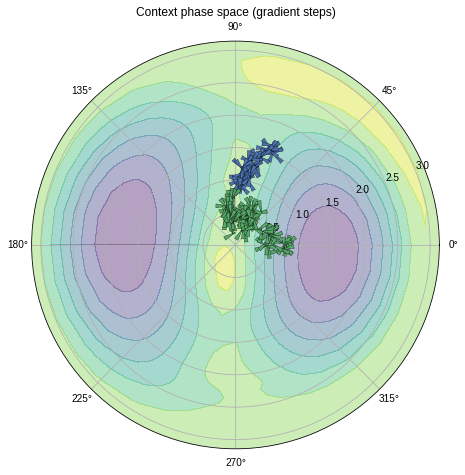

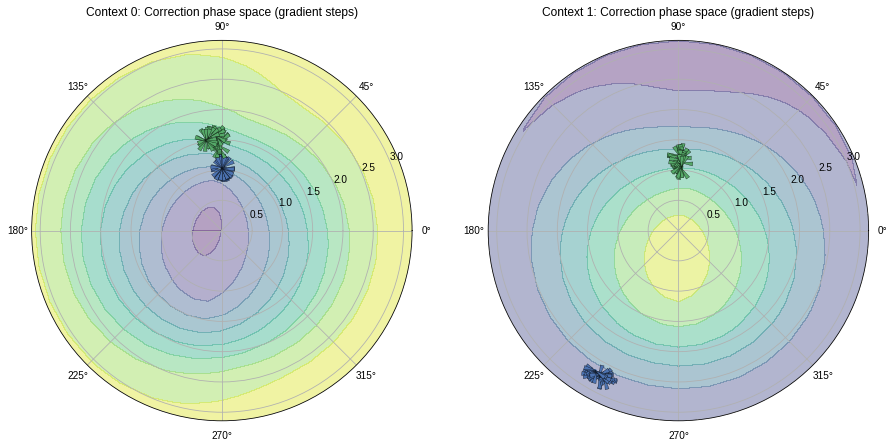

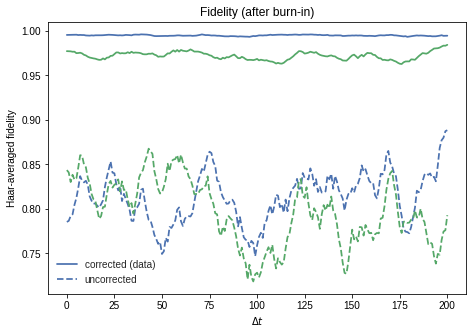

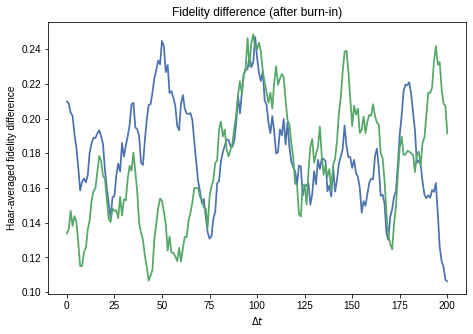

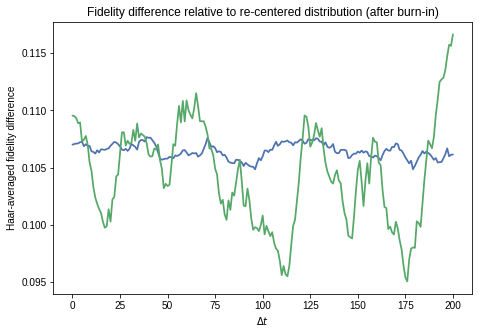

In [10]:
idx = 15
drift_strength = drift_strengths[idx]
parallel_sims_store_red = [p[1] for p in sorted(parallel_sim_stores_all[idx].items())][:2]

batch_size = 1
burnin_length = min(int(numpy.ceil(800 / batch_size)) - 1,
                        int(numpy.ceil(1000 / batch_size) - numpy.ceil(2 * drift_strength / batch_size)))
# Get contour over entire distribution. May need to subset for non-stationary case.
error_samples_generator_partial = functools.partial(
        error_samples_generator, mu=[MU_1, MU_2, MU_3], sigma=[SIGMA_1, SIGMA_2, SIGMA_3], batch_size=2 * drift_strength, drift=numpy.pi / drift_strength)
context_contour = get_contour(error_samples_generator_partial(iteration=0), context_loss)
optimal_phi, optimal_theta = context_contour['max_phi'], context_contour['max_theta']
if optimal_phi > numpy.pi:
    optimal_phi += numpy.pi


# Allows plotting of conditioned correction contours according to the true
# optimal conditioning. Previously, we conditioned based upon the current
# estimator for conditioning.
def condition_error_samples(error_samples, optimal_phi, optimal_theta):
    polling_group = []
    prepared_basis = [snot() * basis(2, 0), snot() * sigmax() * basis(2, 0)]
    for e in error_samples:
        u = get_error_unitary(e, sensitivity=1.0)
        s = u * prepared_basis[0]
        meas = numpy.cos(optimal_theta / 2) * prepared_basis[0] + numpy.exp(
                1j * optimal_phi) * numpy.sin(optimal_theta / 2) * prepared_basis[1]
        meas = meas.unit()
        obj = numpy.real(meas.overlap(s) * s.overlap(meas))
        polling_group.append(obj > 0.5)
    return polling_group


error_samples = numpy.array(error_samples_generator_partial(iteration=0))
cond = numpy.array(condition_error_samples(error_samples, optimal_phi, optimal_theta))
correction_contour = {}
correction_contour[0] = get_contour(error_samples[
    cond], correction_loss)
correction_contour[1] = get_contour(error_samples[
    ~cond], correction_loss)
plot_layered(parallel_sims_store_red, context_contour, correction_contour, burnin_length=burnin_length, window_size=25)

In [ ]:
# ## burnin_length = 10
# d = {
#     "batch_number": numpy.array([]),
#     "context_eta_init": numpy.array([]),
#     "correction_eta_init_0": numpy.array([]),
#     "correction_eta_init_1": numpy.array([]),
#     "relative_fid": numpy.array([])
# }
# for idx, sim in enumerate(parallel_sims):
#         data_fids = numpy.mean(numpy.array([s.data_fidelity_per_episode[burnin_length:] for s in sim]), axis=0)
#         ctrl_fids = numpy.mean(numpy.array([s.control_fidelity_per_episode[burnin_length:] for s in sim]), axis=0)

#         rel_fids = data_fids / ctrl_fids
#         for i, r in enumerate(rel_fids):
#             d["batch_number"] = numpy.append(d["batch_number"], i)
#             d["relative_fid"] = numpy.append(d["relative_fid"], r)
#             d["context_eta_init"] = numpy.append(d["context_eta_init"], sim[0].context_eta_init[0])
#             d["correction_eta_init_0"] = numpy.append(d["correction_eta_init_0"], sim[0].correction_eta_init[0][0])
#             d["correction_eta_init_1"] = numpy.append(d["correction_eta_init_1"], sim[0].correction_eta_init[1][0])


# df = pd.DataFrame.from_dict(d)
# g = sns.relplot(
#     data=df,
#     x="context_eta_init", y="correction_eta_init_0", hue="relative_fid", size="relative_fid"
# )

# # Tweak the figure to finalize
# g.set(xlabel="", ylabel="", aspect="equal")
# g.despine(left=True, bottom=True)
# g.ax.margins(.02)
# for label in g.ax.get_xticklabels():
#     label.set_rotation(90)


## Appendix breakdowns

In [ ]:
# def analytic_context_grad(meas_lo, meas_mid, meas_hi, trans):
#     lo = numpy.array(
#         [numpy.sqrt(t.overlap(meas_lo) * meas_lo.overlap(t)) for t in trans])
#     mid = numpy.array(
#         [numpy.sqrt(t.overlap(meas_mid) * meas_mid.overlap(t)) for t in trans])
#     hi = numpy.array(
#         [numpy.sqrt(t.overlap(meas_hi) * meas_hi.overlap(t)) for t in trans])

#     mean_mid = numpy.mean(mid)
#     mean_lo = numpy.mean(lo)
#     mean_hi = numpy.mean(hi)
#     var_grad = numpy.mean([2 * (m - mean_mid) * ((h - l) - (mean_hi - mean_lo))
#                         for l, m, h in zip(lo, mid, hi)])
#     return var_grad


# # This is the contour of the *gradient* we actually compute using
# # parameter-shift-measurable observables. Spectator qubits achieve a finite
# # sampling of this expectation value.
# def get_analytic_contour(error_samples, num_variational_params=11):
#     prepared_basis = [snot() * basis(2, 0), snot() * sigmax() * basis(2, 0)]
#     trans = [rz(sample) * prepared_basis[0] for sample in error_samples]

#     variational_params = numpy.linspace(-numpy.pi, numpy.pi - (numpy.pi/128),
#                                      num_variational_params)
#     theta_phi_feedback = {}

#     for t_1 in variational_params:
#         for t_2 in variational_params:
#             for t_3 in variational_params:
#                 t = [t_1, t_2, t_3]
#                 unitary_mid = (rz(t[2]) * rx(-numpy.pi/2) * rz(t[1]) *
#                                rx(numpy.pi / 2) * rz(t[0]))

#                 theta_mid, phi_mid = extract_theta_phi(unitary_mid.dag())
#                 meas_mid = (numpy.cos(theta_mid / 2) * prepared_basis[0] + numpy.exp(
#                     1j * phi_mid) * numpy.sin(theta_mid / 2) * prepared_basis[1])
#                 meas_mid = meas_mid.unit()

#                 if (theta_mid, phi_mid) in theta_phi_feedback.keys():
#                     continue

#                 g = []
#                 for i in range(3):
#                     t[i] += -numpy.pi / 2
#                     unitary_lo = (rz(t[2]) * rx(-numpy.pi/2) * rz(t[1]) *
#                                   rx(numpy.pi / 2) * rz(t[0]))
#                     t[i] += numpy.pi
#                     unitary_hi = (rz(t[2]) * rx(-numpy.pi/2) * rz(t[1]) *
#                                   rx(numpy.pi / 2) * rz(t[0]))
#                     t[i] += -numpy.pi / 2

#                     theta_lo, phi_lo = extract_theta_phi(unitary_lo.dag())
#                     theta_hi, phi_hi = extract_theta_phi(unitary_hi.dag())

#                     meas_lo = (numpy.cos(theta_lo / 2) * prepared_basis[0]
#                                + numpy.exp(1j * phi_lo) * numpy.sin(theta_lo / 2)
#                                * prepared_basis[1]).unit()
#                     meas_hi = (numpy.cos(theta_hi / 2) * prepared_basis[0]
#                                + numpy.exp(1j * phi_hi) * numpy.sin(theta_hi / 2)
#                                * prepared_basis[1]).unit()

#                     g.append(analytic_context_grad(meas_lo=meas_lo,
#                                                    meas_mid=meas_mid,
#                                                    meas_hi=meas_hi,
#                                                    trans=trans))

#                 theta_phi_feedback[(round(theta_mid, 2),
#                                     round(phi_mid, 2))] = numpy.linalg.norm(g)

#     theta_grid = []
#     phi_grid = []
#     feedback = []

#     for (t, p), f in theta_phi_feedback.items():
#         theta_grid.append(t)
#         phi_grid.append(p)
#         feedback.append(f)
#     theta_grid = numpy.array(theta_grid)
#     phi_grid = numpy.array(phi_grid)
#     mesh_theta = mesh_phi = numpy.linspace(-numpy.pi, numpy.pi,
#                                         len(variational_params ** 3))
#     mesh_theta, mesh_phi = numpy.meshgrid(mesh_theta, mesh_phi)

#     # Interpolate using radial basis kernel.
#     rbf = scipy.interpolate.Rbf(theta_grid, phi_grid, feedback,
#                                 function='linear')
#     loss = rbf(mesh_theta, mesh_phi)

#     return {'mesh_phi': mesh_phi, 'mesh_theta': mesh_theta, 'loss': loss}

In [ ]:
# # This is very slow. O(n^3) computation, for n=num_variational_params.
# context_analytic_contour = get_analytic_contour(ERROR_SAMPLES,
#                                                 num_variational_params=15)
# print(len(context_analytic_contour['mesh_phi']))

In [ ]:
# f, a = plt.subplots(1, 1, figsize=(7.5, 7.5), subplot_kw=dict(polar=True))
# CS = a.contourf(context_analytic_contour['mesh_phi'],
#                 context_analytic_contour['mesh_theta'],
#                 context_analytic_contour['loss'])
# a.scatter(x=[numpy.pi/2], y=[numpy.pi/2], label='ideal')
# # a.clabel(CS, inline=True, fontsize=14, colors='r',
# #          manual=[(-numpy.pi/2, numpy.pi/2)])
# a.legend()
# a.set_title("True analytic context gradient magnitude")

# cbar = f.colorbar(CS)
# f.show()